# Final Project: Newspaper Headline/Landing Page Predicting Stock Market data

Layout:

1. Wayback machine and look into API's......see if any of the API's return the json. If I can't webscraping beutiful soup selnium....use selenium to click on a day and then the time. Maybe see what the top company.....then predict that companies stock.      
2. Do the headlines impact todays or tomorrows price.....index will be the stock price.  
3. NLP....tokenize. Remove stop words
4. Modeling: LSTM neural network or boosting/ensemble methods.....maybe model stacking 
  
Notes:  
- Data Sources: Stock data-Yahoo Finance, & Newspaper data-waybackmachine
- Do not use a CNN for this problem 
- Check out LSTM Neural Network 
- Pretrained word embedding 
- Avoid doing a day at a time do more batch
- Try maybe one newspaper at a time and try a different model for each
- Wayback machine for data



In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import nltk
from nltk.tokenize import word_tokenize
np.random.seed(0)
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

## Retrieve Data

First we need to retrieve the financial market data from yahoo finance. Historical data in the form of a csv is available through direct download at the following link, https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC.

In [2]:
sp_500=pd.read_csv('S&P 500 Data.csv')

In [3]:
sp_500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/22/2018,2773.939941,2778.939941,2749.219971,2755.879883,2755.879883,3307140000
1,10/23/2018,2721.030029,2753.590088,2691.429932,2740.689941,2740.689941,4348580000
2,10/24/2018,2737.870117,2742.590088,2651.889893,2656.100098,2656.100098,4709310000
3,10/25/2018,2674.879883,2722.699951,2667.840088,2705.570068,2705.570068,4634770000
4,10/26/2018,2667.860107,2692.379883,2628.159912,2658.689941,2658.689941,4803150000


In [4]:
sp_500['Change']=sp_500['Close']-sp_500['Open']

In [5]:
sp_500_final= sp_500[['Date','Change']]

In [6]:
sp_500_final.head()

,Date,Change
0,10/22/2018,-18.060058
1,10/23/2018,19.659912
2,10/24/2018,-81.770019
3,10/25/2018,30.690185
4,10/26/2018,-9.170166


In [7]:
Encode=pd.DataFrame(sp_500_final['Change'].where(sp_500_final['Change']<0, other=1))

In [8]:
encoded_data=pd.DataFrame(Encode.where(Encode>0,-1))

In [9]:
encoded_data.columns=['Coded']

In [10]:
sp_500=pd.concat([sp_500_final,encoded_data], axis=1)

In [11]:
sp_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 3 columns):
Date      251 non-null object
Change    251 non-null float64
Coded     251 non-null float64
dtypes: float64(2), object(1)
memory usage: 6.0+ KB


In [12]:
sp_500.Date = pd.to_datetime(sp_500.Date)

In [13]:
sp_500.head()

,Date,Change,Coded
0,2018-10-22,-18.060058,-1.0
1,2018-10-23,19.659912,1.0
2,2018-10-24,-81.770019,-1.0
3,2018-10-25,30.690185,1.0
4,2018-10-26,-9.170166,-1.0


Now to use Beautful Soup to webscrape the wayback machine. The wayback machine is a open source website that stores historical webcrawls of many websites. I am going to use the wayback machine to webscrape the WSJ front page. From there I will scrape just the headlines and the sub headings to perform Natural Language Processing. 

In [14]:
url= 'https://web.archive.org/web/*/wsj.com'
driver = webdriver.Chrome(executable_path=r'C:\Users\GBLS\Downloads\chromedriver_win32\chromedriver')
driver.get('https://web.archive.org/web/*/wsj.com')

# python_button= driver.find_element_by_id


In [15]:
# python_button = driver.find_element_by_id('s3xx snapshot-link"')
# python_button.click()
# driver.implicitly_wait(30)
# continue_link = driver.find_element_by_link_text('1')
# continue_link.click()

In [15]:
my_html = driver.page_source
soup = BeautifulSoup(my_html, 'html.parser')

In [16]:
print(soup.prettify())

<html lang="en">
 <head>
  <title>
   Wayback Machine
  </title>
  <script src="//archive.org/includes/jquery-1.10.2.min.js?v1.10.2" type="text/javascript">
  </script>
  <script src="//archive.org/includes/analytics.js?v=1fa7096c" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/npm/jquery-ui.min.js?v1.12.1" type="text/javascript">
  </script>
  <script src="//archive.org/includes/bootstrap.min.js?v3.0.0" type="text/javascript">
  </script>
  <script src="//archive.org/components/npm/clipboard/dist/clipboard.js?v=1fa7096c" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/npm/react/umd/react.production.min.js?v16.7.0" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/npm/react-dom/umd/react-dom.production.min.js?v16.7.0" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/js/archive.min.js?v=1fa7096c" type="text/javascript">
  </script>
  <script src="//archive.org/in

In [17]:
links=soup.find_all('a')

In [18]:
links

[<a data-action="ia-banner-close" href="#"></a>,
 <a class="navia-link home" href="/" target="_top" title="Home">
 <span class="iconochive-logo"></span>
 <span>Home</span>
 </a>,
 <a class="navia-link web" data-top-kind="web" href="https://archive.org/web/" target="_top" title="Web"><span aria-hidden="true" class="iconochive-web"></span><span>web</span></a>,
 <a class="navia-link texts" data-top-kind="texts" href="https://archive.org/details/texts" target="_top" title="Texts"><span aria-hidden="true" class="iconochive-texts"></span><span>books</span></a>,
 <a class="navia-link movies" data-top-kind="movies" href="https://archive.org/details/movies" target="_top" title="Video"><span aria-hidden="true" class="iconochive-movies"></span><span>video</span></a>,
 <a class="navia-link audio" data-top-kind="audio" href="https://archive.org/details/audio" target="_top" title="Audio"><span aria-hidden="true" class="iconochive-audio"></span><span>audio</span></a>,
 <a class="navia-link software" 

In [19]:
links_wsj= []
for x in links:
    if 'wsj' in x['href']:
        links_wsj.append(x['href'])

In [20]:
links_wsj

['/web/collections/*/wsj.com',
 '/web/changes/wsj.com',
 '/details/wsj.com',
 '/web/sitemap/wsj.com',
 '/web/19961203131021/wsj.com',
 '/web/20191104140015/wsj.com',
 '/web/20190101/wsj.com',
 '/web/20190102/wsj.com',
 '/web/20190103/wsj.com',
 '/web/20190104/wsj.com',
 '/web/20190105/wsj.com',
 '/web/20190106/wsj.com',
 '/web/20190107/wsj.com',
 '/web/20190108/wsj.com',
 '/web/20190109/wsj.com',
 '/web/20190110/wsj.com',
 '/web/20190111/wsj.com',
 '/web/20190112/wsj.com',
 '/web/20190113/wsj.com',
 '/web/20190114/wsj.com',
 '/web/20190115/wsj.com',
 '/web/20190116/wsj.com',
 '/web/20190117/wsj.com',
 '/web/20190118/wsj.com',
 '/web/20190119/wsj.com',
 '/web/20190120/wsj.com',
 '/web/20190121/wsj.com',
 '/web/20190122/wsj.com',
 '/web/20190123/wsj.com',
 '/web/20190124/wsj.com',
 '/web/20190125/wsj.com',
 '/web/20190126/wsj.com',
 '/web/20190127/wsj.com',
 '/web/20190128/wsj.com',
 '/web/20190129/wsj.com',
 '/web/20190130/wsj.com',
 '/web/20190131/wsj.com',
 '/web/20190201/wsj.com',
 '

In [21]:
full_link= []
for x in links_wsj:
    full_link.append('https://web.archive.org/'+ x)

In [22]:
full_link

['https://web.archive.org//web/collections/*/wsj.com',
 'https://web.archive.org//web/changes/wsj.com',
 'https://web.archive.org//details/wsj.com',
 'https://web.archive.org//web/sitemap/wsj.com',
 'https://web.archive.org//web/19961203131021/wsj.com',
 'https://web.archive.org//web/20191104140015/wsj.com',
 'https://web.archive.org//web/20190101/wsj.com',
 'https://web.archive.org//web/20190102/wsj.com',
 'https://web.archive.org//web/20190103/wsj.com',
 'https://web.archive.org//web/20190104/wsj.com',
 'https://web.archive.org//web/20190105/wsj.com',
 'https://web.archive.org//web/20190106/wsj.com',
 'https://web.archive.org//web/20190107/wsj.com',
 'https://web.archive.org//web/20190108/wsj.com',
 'https://web.archive.org//web/20190109/wsj.com',
 'https://web.archive.org//web/20190110/wsj.com',
 'https://web.archive.org//web/20190111/wsj.com',
 'https://web.archive.org//web/20190112/wsj.com',
 'https://web.archive.org//web/20190113/wsj.com',
 'https://web.archive.org//web/20190114/

In [28]:
jan=full_link[6:37]
feb=full_link[37:65]
mar=full_link[65:96]
apr=full_link[96:126]
may=full_link[126:157]
jun=full_link[157:187]
jul=full_link[187:218]
aug=full_link[218:249]
sept=full_link[249:279]
octb=full_link[279:310]

In [88]:
# driver.get(str(january[0]))
# my_html= driver.page_source
# soup= BeautifulSoup(my_html, 'html.parser')
# for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
#     print(div.contents[0])

In [103]:
# #FUNCTION 
# def webscrape_month(month):
#     date=[]
#     headline_blurb_data= []
#     for link in month: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
#         driver.get(str(link))
#         my_html= driver.page_source
#         soup= BeautifulSoup(my_html, 'html.parser')
#         for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
#             headline_blurb_data.append(div.contents[0])
#             date.append(str(link)[29:37])
#         for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
#             headline_blurb_data.append(div.text)
#             date.append(str(link)[29:37])
#     df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
#     df_wsj.Date= pd.to_datetime(df_wsj.Date)
#     df_final=df_wsj.merge(sp_500,how='left')
#     df_final=df_final.ffill(axis=0)
#     df_final.to_csv(str(month))

In [29]:
date=[]
headline_blurb_data= []
for link in jan: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_jan=df_wsj.merge(sp_500,how='left')

In [31]:
df_jan=df_jan.fillna(1)

In [32]:
df_jan.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [33]:
df_jan.to_csv('January')

In [34]:
date=[]
headline_blurb_data= []
for link in feb: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_feb=df_wsj.merge(sp_500,how='left') 

In [35]:
df_feb.head()

,Date,Text,Change,Coded
0,2019-02-01,1MDB Scandal Could Hit Pay for Some Top Goldma...,4.209961,1.0
1,2019-02-01,Job Market Powers Past Headwinds as Payrolls E...,4.209961,1.0
2,2019-02-01,Virginia Governor Apologizes for Racist Medica...,4.209961,1.0
3,2019-02-01,Big Oil Companies Finished 2018 Strong Despite...,4.209961,1.0
4,2019-02-01,Inspectors of Collapsed Brazilian Dam Had Clos...,4.209961,1.0


In [36]:
df_feb=df_feb.ffill(axis=0)
df_feb.to_csv('Febuary')

In [37]:
date=[]
headline_blurb_data= []
for link in mar: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_mar=df_wsj.merge(sp_500,how='left') 

In [38]:
df_mar=df_mar.ffill(axis=0)

In [39]:
df_mar.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [40]:
df_mar.to_csv('March')

In [41]:
date=[]
headline_blurb_data= []
for link in apr: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_apr=df_wsj.merge(sp_500,how='left')
df_apr=df_apr.ffill(axis=0)

In [42]:
df_apr.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [43]:
df_apr.to_csv('April')

In [44]:
df_apr.head()

,Date,Text,Change,Coded
0,2019-04-01,"U.S. and Chinese Manufacturing Stabilize, Whil...",18.560058,1.0
1,2019-04-01,Stocks Rise as China Data Ease Concerns Over G...,18.560058,1.0
2,2019-04-01,Slack Picks NYSE for Direct Listing,18.560058,1.0
3,2019-04-01,U.K. Lawmakers Closer to Brexit Alternatives b...,18.560058,1.0
4,2019-04-01,Amazon Cuts More Prices at Whole Foods,18.560058,1.0


In [45]:
date=[]
headline_blurb_data= []
for link in may: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_may=df_wsj.merge(sp_500,how='left')
df_may=df_may.ffill(axis=0)

In [46]:
print(df_may.isna().sum())
df_may.head()

Date      0
Text      0
Change    0
Coded     0
dtype: int64


,Date,Text,Change,Coded
0,2019-05-01,"Fed Leaves Rates Unchanged, Notes Subdued Infl...",-28.600098,-1.0
1,2019-05-01,Qualcomm to Get at Least $4.5 Billion in Apple...,-28.600098,-1.0
2,2019-05-01,U.K.’s May Fires Defense Secretary Over Huawei...,-28.600098,-1.0
3,2019-05-01,Family Paid $6.5 Million to Get Their Daughter...,-28.600098,-1.0
4,2019-05-01,"Barr, Democrats Clash Over Mueller Report",-28.600098,-1.0


In [47]:
df_may.to_csv('May')

In [130]:
df_may.tail()

,Date,Text,Change,Coded
3604,2019-05-31,U.S. and South Korean authorities are looking ...,14.089843,1.0
3605,2019-05-31,"The Trump administration has delayed new, toug...",14.089843,1.0
3606,2019-05-31,A Syrian detention center run by U.S.-backed K...,14.089843,1.0
3607,2019-05-31,Silent retreats offer a respite from our clamo...,14.089843,1.0
3608,2019-05-31,Ask Encore columnist Glenn Ruffenach also answ...,14.089843,1.0


In [48]:
date=[]
headline_blurb_data= []
for link in jun: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_jun=df_wsj.merge(sp_500,how='left')
df_jun=df_jun.ffill(axis=0)

In [49]:
df_jun.head()

,Date,Text,Change,Coded
0,2019-06-01,Justice Department Prepares Antitrust Probe of...,NaN,NaN
1,2019-06-01,Tariffs on Mexican Imports Would Hit More Than...,NaN,NaN
2,2019-06-01,"Factories Stall on Strong Dollar, Trade Tensions",NaN,NaN
3,2019-06-01,FedEx Caught in U.S.-China Tensions,NaN,NaN
4,2019-06-01,Virginia Beach Grieves Deaths of 12 Shooting V...,NaN,NaN


In [50]:
df_jun=df_jun.fillna(1)

In [51]:
df_jun.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [52]:
df_jun.to_csv('June')

In [53]:
df_jun.head()

,Date,Text,Change,Coded
0,2019-06-01,Justice Department Prepares Antitrust Probe of...,1.0,1.0
1,2019-06-01,Tariffs on Mexican Imports Would Hit More Than...,1.0,1.0
2,2019-06-01,"Factories Stall on Strong Dollar, Trade Tensions",1.0,1.0
3,2019-06-01,FedEx Caught in U.S.-China Tensions,1.0,1.0
4,2019-06-01,Virginia Beach Grieves Deaths of 12 Shooting V...,1.0,1.0


In [54]:
date=[]
headline_blurb_data= []
for link in jul: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_jul=df_wsj.merge(sp_500,how='left') 
df_jul=df_jul.ffill(axis=0)

In [55]:
df_jul.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [56]:
df_jul.to_csv('July')

In [57]:
df_jul.tail()

,Date,Text,Change,Coded
4363,2019-07-31,Opinion: The 99% Get a Bigger Raise,-35.840088,-1.0
4364,2019-07-31,Anxiety Looks Different in Men,-35.840088,-1.0
4365,2019-07-31,"A Generation of Siblings, Raised to Be Entrepr...",-35.840088,-1.0
4366,2019-07-31,They Were Huge Franchises. Why Did They Collapse?,-35.840088,-1.0
4367,2019-07-31,One Bookstore Finds the Secret to Succeeding i...,-35.840088,-1.0


In [58]:
date=[]
headline_blurb_data= []
for link in aug: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_aug=df_wsj.merge(sp_500,how='left') 
df_aug=df_aug.ffill(axis=0)

In [59]:
df_aug=df_aug.ffill(axis=0)

In [60]:
df_aug.to_csv('August')

In [61]:
date=[]
headline_blurb_data= []
for link in sept: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_sept=df_wsj.merge(sp_500,how='left') 
df_sept=df_sept.ffill(axis=0)

In [62]:
df_aug.tail()

,Date,Text,Change,Coded
3334,2019-08-31,Opinion: A Feminist Capitalist Professor Under...,-10.630127,-1.0
3335,2019-08-31,Rob Gronkowski Lost Weight and Changed His Life,-10.630127,-1.0
3336,2019-08-31,An Obituary Writer Is Writing His Own Obituary,-10.630127,-1.0
3337,2019-08-31,Banks Monitor Older Customers for Cognitive De...,-10.630127,-1.0
3338,2019-08-31,Smart Financial Strategies Between Retirement ...,-10.630127,-1.0


In [63]:
df_sept=df_sept.fillna(1)

In [64]:
df_sept.to_csv('September')

In [65]:
date=[]
headline_blurb_data= []
for link in octb: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_octb=df_wsj.merge(sp_500,how='left') 
df_octb=df_octb.ffill(axis=0)

In [66]:
df_octb.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [67]:
df_octb.to_csv('October')

In [234]:
df_jan= pd.read_csv('January')

In [236]:
df_feb=pd.read_csv('Febuary')

In [237]:
df_mar=pd.read_csv('March')

In [238]:
df_apr=pd.read_csv('April')

In [239]:
df_may=pd.read_csv('May')

In [240]:
df_jun=pd.read_csv('June')

In [241]:
df_jul=pd.read_csv('July')

In [242]:
df_aug=pd.read_csv('Aug')

In [243]:
df_sept=pd.read_csv('September')

In [244]:
df_octb=pd.read_csv('October')

In [68]:
df_jan_oct_final=pd.concat([df_jan,df_feb,df_mar,df_apr,df_may,df_jun,df_jul,df_aug,df_sept,df_octb])

In [69]:
df_jan_oct_final=df_jan_oct_final.reset_index(drop=True)

In [70]:
df_jan_oct_final

,Date,Text,Change,Coded
0,2019-01-01,Trump Invites Top Lawmakers in Effort To End S...,1.000000,1.0
1,2019-01-01,Kim Jong Un Extends Peace Overture to U.S.,1.000000,1.0
2,2019-01-01,"American Detained in Russia Isn’t a Spy, Famil...",1.000000,1.0
3,2019-01-01,The Money Managers to Watch in 2019,1.000000,1.0
4,2019-01-01,Investors Try Not to Panic Over Stock Volatility,1.000000,1.0
5,2019-01-01,Rewards Credit Cards Gained a Fanatic Followin...,1.000000,1.0
6,2019-01-01,Chesapeake Energy Bet on Oil. Then Crude Price...,1.000000,1.0
7,2019-01-01,Brazil’s Idea to Fix Rampant Gun Violence: Mor...,1.000000,1.0
8,2019-01-01,"Conservative Takes Reins in Brazil, Vows to Re...",1.000000,1.0
9,2019-01-01,"To Woo Millennials, Atlanta Weighs Parks Over ...",1.000000,1.0


In [71]:
df_jan_oct_final.to_csv('January-October',index=False)

1. Loading the text  
2. Split the tokens  
3. Convert to lowercase 
4. Remove punctation 
5. Filter out remaining tokens that are not alphabetic
6. Filter out otken that are stop words

Stemming words

## SCRATCH SPACE

In [22]:
# final=pd.read_csv('January-October')

In [104]:
df=pd.read_csv('January-October')

In [105]:
df.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [106]:
positive=df[df['Coded']==1]#split into negative and positive days
negative=df[df['Coded']==-1]

In [107]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',"’", '‘','said','says', "'s",'”','“']

In [108]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [109]:
stopwords_lowercase=['i','me','my','myself','we','our','ours','ourselves',
 'you', "you're", "you've", "you'll","you'd", 'your','yours', 'yourself',
'yourselves', 'he','him','his', 'himself','she', "she's",
 'her', 'hers','herself','it', "it's",'its', 'itself','they', 'them','their', 'theirs',
 'themselves','what', 'which','who', 'whom','this', 'that',
 "that'll", 'these','those', 'am','is', 'are','was', 'were',
 'be', 'been','being', 'have', 'has', 'had','having', 'do',
 'does', 'did','doing', 'a', 'an', 'the','and', 'but',
 'if', 'or','because','as','until', 'while','of','at','by', 'for','with','about','against',
 'between','into','through','during', 'before','after','above','below',
 'to','from','up','down', 'in','out','on','off',
 'over','under','again','further', 'then','once','here','there',
 'when','where','why','how', 'all','any','both','each', 'few','more',
 'most','other', 'some','such', 'no','nor', 'not','only',
 'own','same', 'so','than', 'too','very', 's','t',
 'can','will','just','don', "don't",'should', "should've",'now',
 'd','ll', 'm','o', 're','ve', 'y','ain',
 'aren',"aren't", 'couldn',"couldn't", 'didn',"didn't", 'doesn',"doesn't",
 'hadn',"hadn't", 'hasn',"hasn't", 'haven',"haven't", 'isn',"isn't",
 'ma','mightn', "mightn't",'mustn', "mustn't",'needn', "needn't",'shan',
 "shan't",'shouldn',"shouldn't",'wasn',"wasn't",
 'weren',"weren't", 'won',"won't", 'wouldn',"wouldn't"]

In [110]:
for x in stopwords_lowercase:
    stopwords_list.append(x.capitalize())

In [111]:
tokenized_positive=positive['Text'].apply(nltk.word_tokenize)
tokenized_negative=negative['Text'].apply(nltk.word_tokenize)

In [112]:
positive_tokens=[] #Use this to take out all of the stop words 
for x in tokenized_positive:
    for y in x:
        if y not in stopwords_list:
            positive_tokens.append(y.lower())

In [116]:
FreqDist_positive=dict(FreqDist(positive_tokens).most_common(10))

In [114]:
negative_tokens=[] #Use this to take out all of the stop words 
for x in tokenized_negative:
    for y in x:
        if y not in stopwords_list:
            negative_tokens.append(y.lower())

In [117]:
FreqDist_negative=dict(FreqDist(negative_tokens).most_common(10))

It is very interesting to see the top words from a positive vs. negative change in the S&P 500. See below for a graph of each

Text(0.5, 1.0, 'Positive S&P 500 Top 10 Word Vectors January')

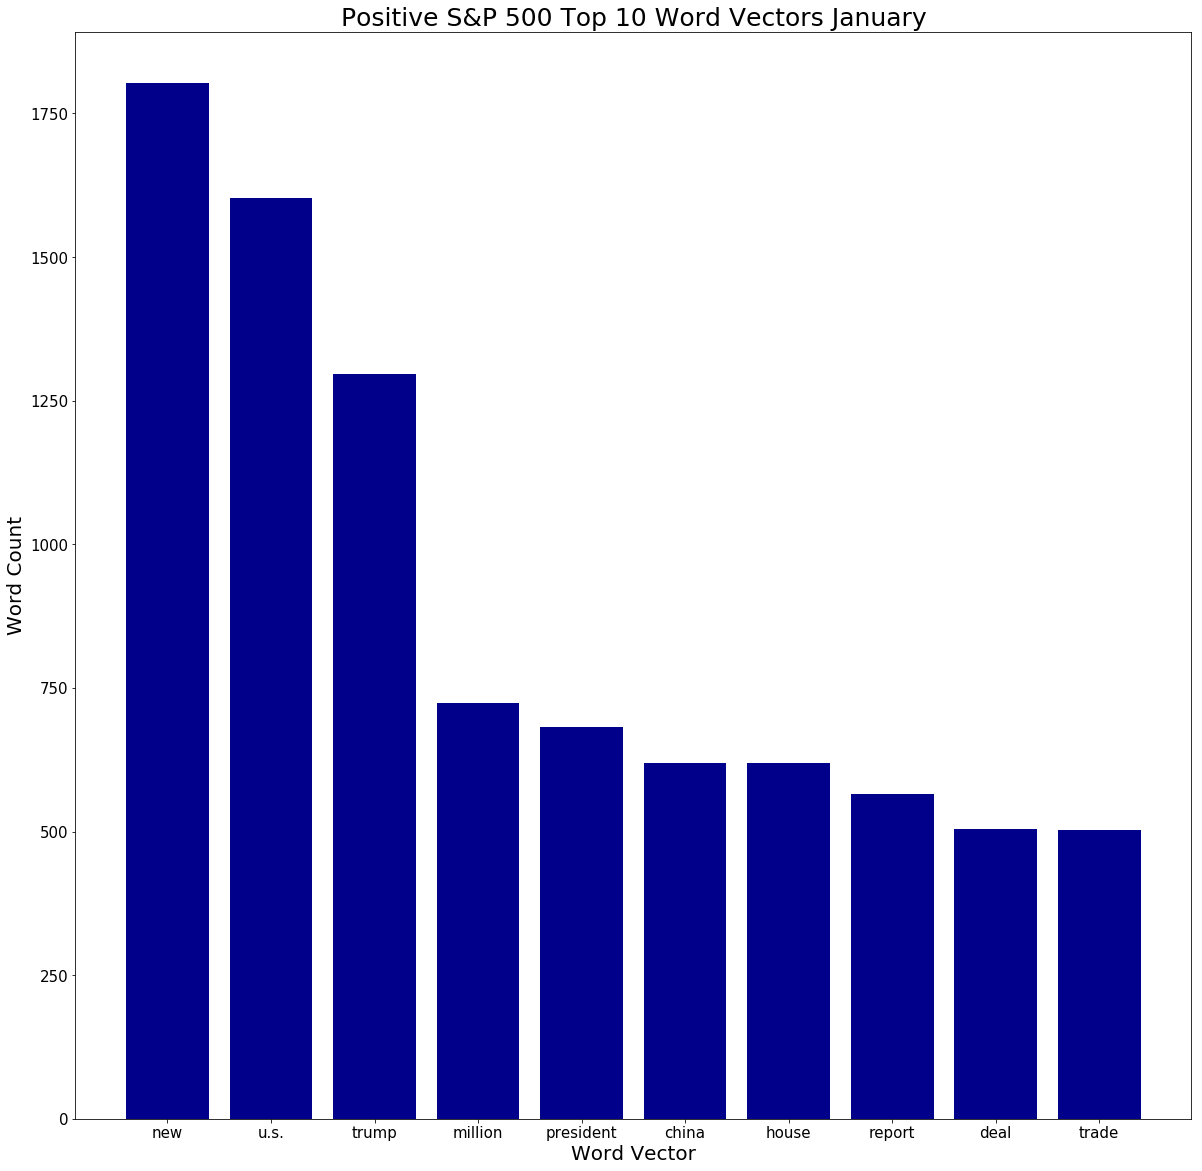

In [118]:
plt.figure(figsize=(20,20))
plt.bar(x=FreqDist_positive.keys(),
        height=FreqDist_positive.values(),
        color='darkblue')
plt.tick_params(labelsize=15)
plt.xlabel('Word Vector',size=20)
plt.ylabel('Word Count',size=20)
plt.title('Positive S&P 500 Top 10 Word Vectors January', size=25)

Text(0.5, 1.0, 'Negative S&P 500 Top 10 Word Vectors January')

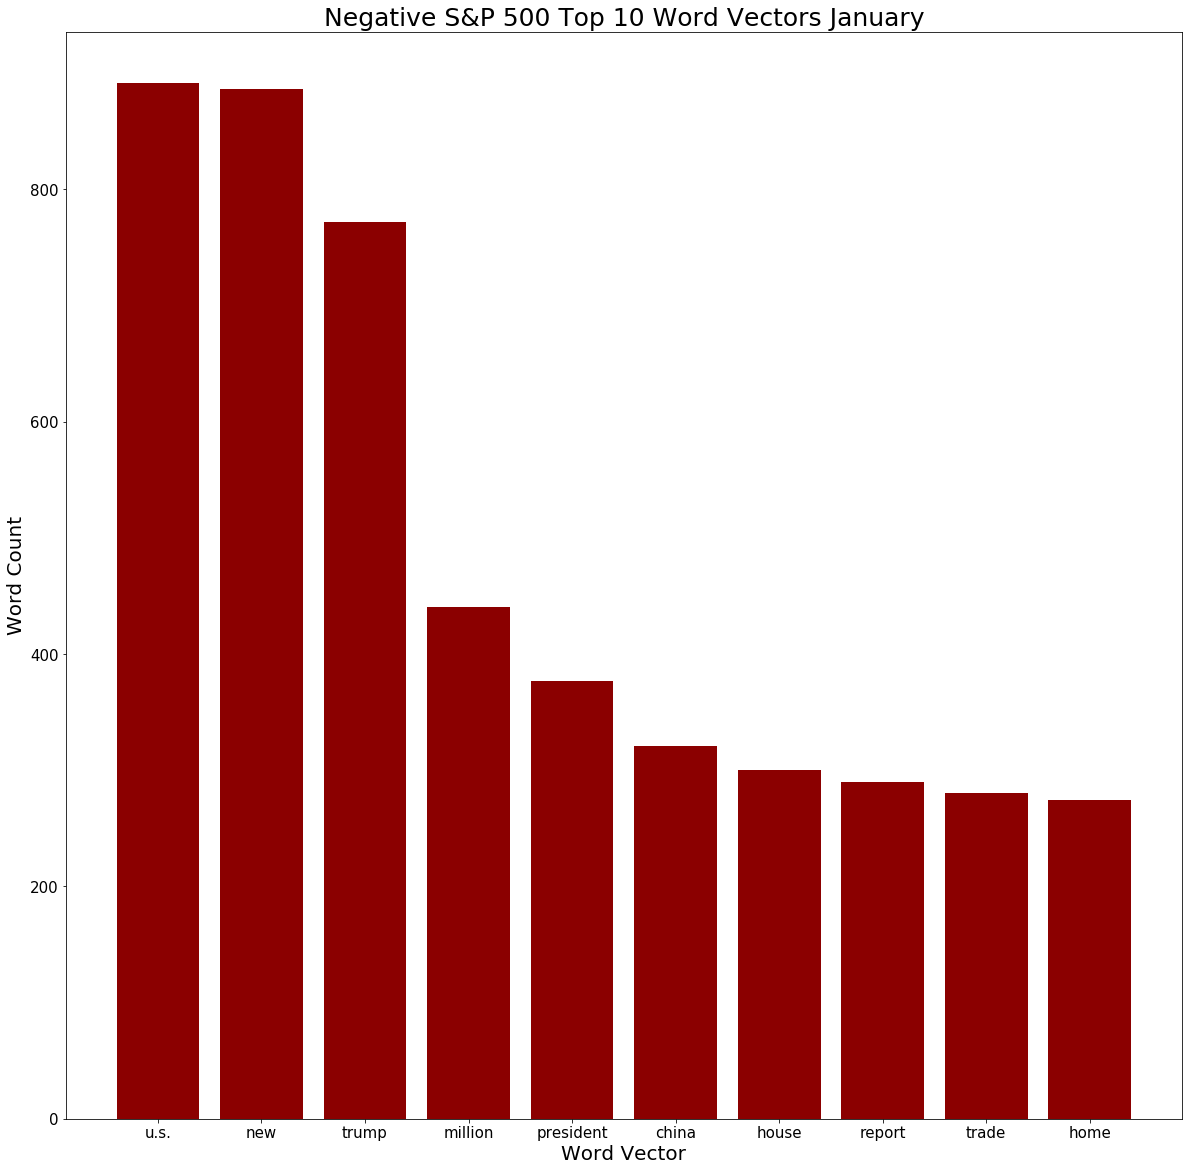

In [119]:
plt.figure(figsize=(20,20))
plt.bar(x=FreqDist_negative.keys(),
        height=FreqDist_negative.values(),
        color='darkred')
plt.tick_params(labelsize=15)
plt.xlabel('Word Vector',size=20)
plt.ylabel('Word Count',size=20)
plt.title('Negative S&P 500 Top 10 Word Vectors January', size=25)


In [86]:
tokenized_df=df['Text'].apply(nltk.word_tokenize)
df_tokens=[] #Use this to take out all of the stop words 
for x in tokenized_df:
    for y in x:
        if y not in stopwords_list:
            df_tokens.append(y.lower())

In [87]:
df_freq_dist=dict(FreqDist(df_tokens).most_common(10))

In [182]:
df_freq_dist

{'new': 2688,
 'u.s.': 2493,
 'trump': 2069,
 'million': 1163,
 'president': 1058,
 'china': 941,
 'house': 919,
 'report': 856,
 'trade': 782,
 'deal': 745}

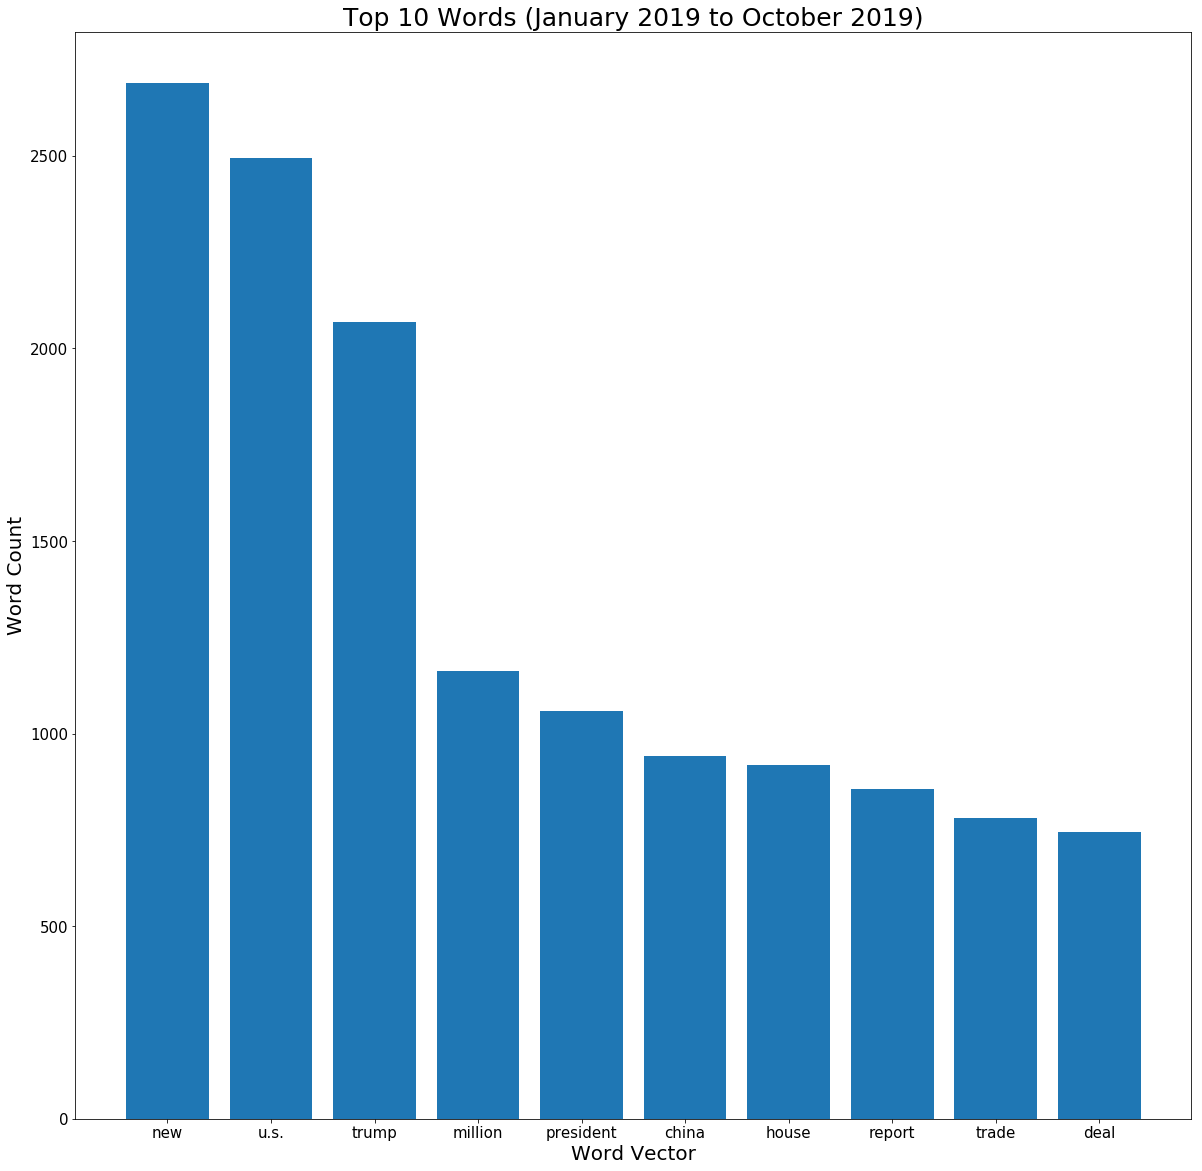

In [89]:
plt.figure(figsize=(20,20))
plt.bar(x=df_freq_dist.keys(),
        height=df_freq_dist.values())
plt.tick_params(labelsize=15)
plt.xlabel('Word Vector',size=20)
plt.ylabel('Word Count',size=20)
plt.title('Top 10 Words (January 2019 to October 2019)', size=25)
plt.show()

In [192]:
df_tokens_freq_dist=FreqDist(df_tokens)
total_word_count = sum(df_tokens_freq_dist.values())
wsj_top_50 =df_tokens_freq_dist.most_common(50)
print("Word\t\t\tNormalized Frequency")
for word in wsj_top_50:
    normalized_frequency = word[1] / total_word_count
    print("{} \t{:.4}".format(word[0], normalized_frequency))

Word			Normalized Frequency
new 	0.008286
u.s. 	0.007685
trump 	0.006378
million 	0.003585
president 	0.003261
china 	0.002901
house 	0.002833
report 	0.002639
trade 	0.00241
deal 	0.002296
could 	0.002241
company 	0.002207
says 	0.002139
market 	0.002124
home 	0.00205
year 	0.002038
two 	0.001994
one 	0.001945
companies 	0.001942
first 	0.001914
week 	0.00188
stock 	0.001837
world 	0.001825
billion 	0.001819
former 	0.001816
big 	0.001782
fed 	0.001742
federal 	0.001695
york 	0.001683
business 	0.001674
state 	0.001612
would 	0.001578
people 	0.001566
u.s 	0.00156
sales 	0.00155
investors 	0.001547
growth 	0.001517
years 	0.00148
tech 	0.001464
chief 	0.001458
today 	0.001433
amazon 	0.001421
ceo 	0.001421
stocks 	0.00139
facebook 	0.00139
back 	0.001384
government 	0.001372
logistics 	0.001338
global 	0.001325
next 	0.001288


After looking at the most common words in the WSJ headline and subheaders, I have decided to take out says and said. I will add these to the stop words list.  
In addition, just a few observations:
    1. New, U.S, Trump are the most common words for both positive and negative SP 500 days.
    2. The only country besides the US that appeared in the bag of words was China. This is expected as over the past year a trade deal with China has been at the forefront of the American agenda. 
    3. The words report and house appear in all three charts. It is interesting that Mueller does not appear as well considering a lot of the report tokens I would imagine have to deal with the investigation conducted by Robert Muller.
    
Next I would like to do a little bit of EDA by further investigating the differences in the top 100 words between negative and positive changes in the SP 500. In addition, I would like to look into all the text that had report in it to see if my Robert Mueller hunch is correct.

## EDA Abs. Difference 

In [120]:
top_100_negative=dict(FreqDist(negative_tokens).most_common(100))

In [121]:
top_100_positive=dict(FreqDist(positive_tokens).most_common(100))

In [122]:
neg_100_df=pd.DataFrame.from_dict(top_100_negative, orient='index', columns=['Count'])

In [123]:
pos_100_df=pd.DataFrame.from_dict(top_100_positive, orient='index',columns=['Count'])

In [124]:
pos_and_neg=pd.merge(neg_100_df,pos_100_df,left_index=True,right_index=True)

In [126]:
pos_and_neg.columns=['Negative','Positive']

In [127]:
pos_and_neg['Abs. Diff']= abs(pos_and_neg['Negative']-pos_and_neg['Positive'])

In [128]:
pos_and_neg.sort_values('Abs. Diff',ascending=False, inplace=True)

In [236]:
pos_and_neg.head(25)

,Negative,Positive,Abs. Diff
new,886,1802,916
u.s.,891,1602,711
trump,772,1297,525
house,300,619,319
president,377,681,304
china,321,620,299
million,440,723,283
report,290,566,276
deal,240,505,265
year,201,460,259


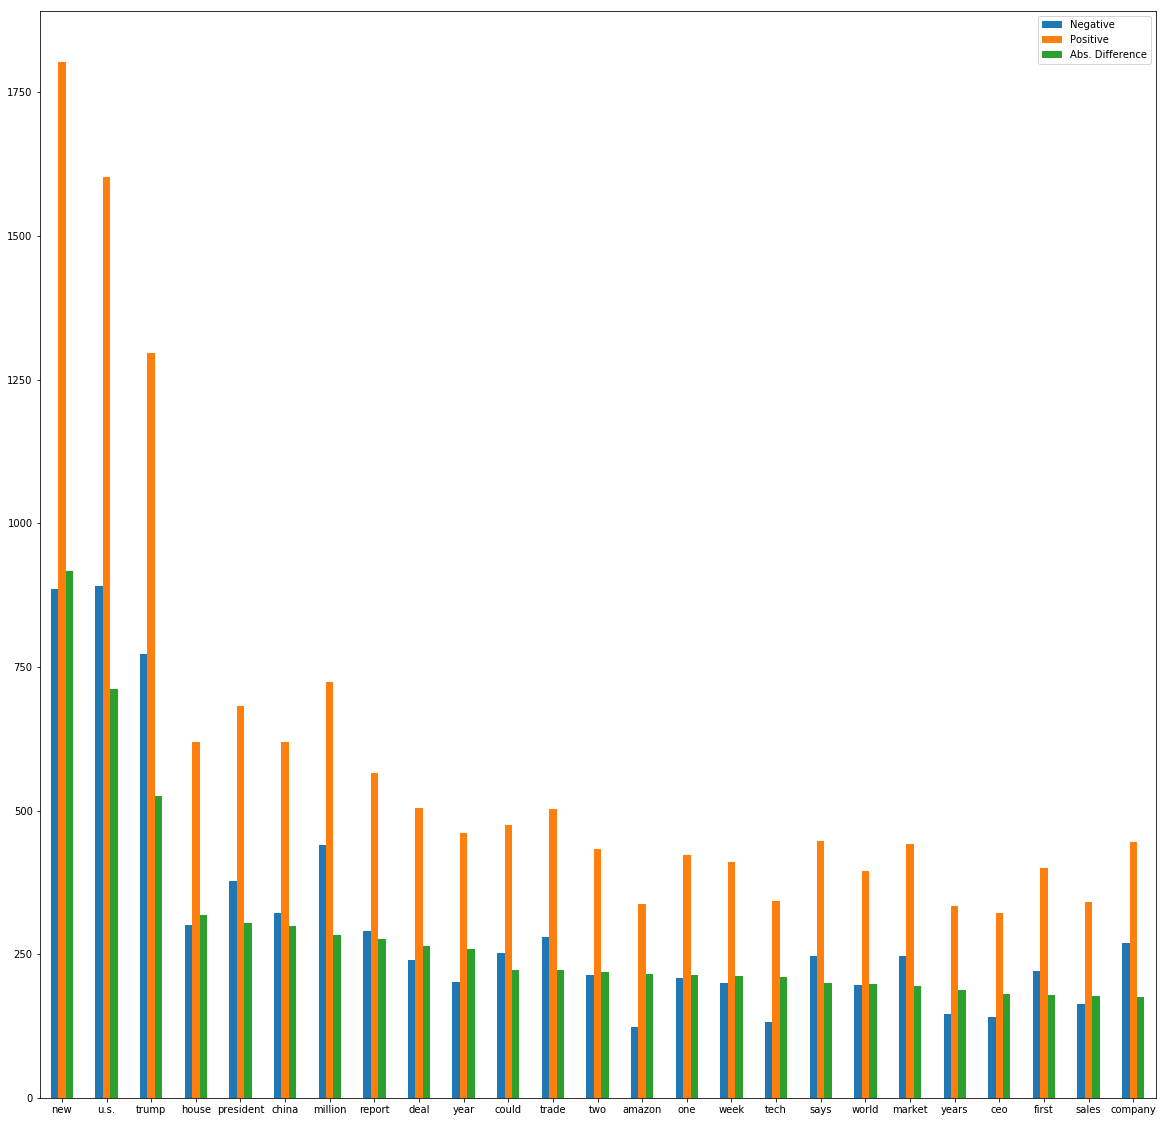

In [176]:
index = pos_and_neg.index[:25]
df_bar = pd.DataFrame({'Negative': pos_and_neg['Negative'][:25], 'Positive': pos_and_neg['Positive'][:25], 'Abs. Difference': pos_and_neg['Abs. Diff'][:25]}, index=index)
ax = df_bar.plot.bar(rot=0,figsize=(20,20))

## EDA Word Clouds

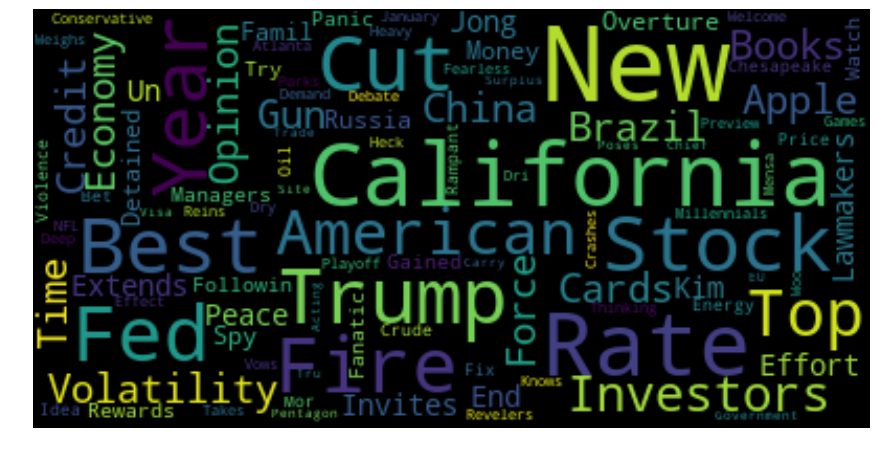

In [128]:
text= str(df['Text'])

wordcloud = WordCloud(stopwords=stopwords_list,max_font_size=50, max_words=100, background_color="black").generate(str(text))

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [198]:
wsj_mask= np.array(Image.open(r'C:\Users\GBLS\Desktop\wsj-social-share.png'))

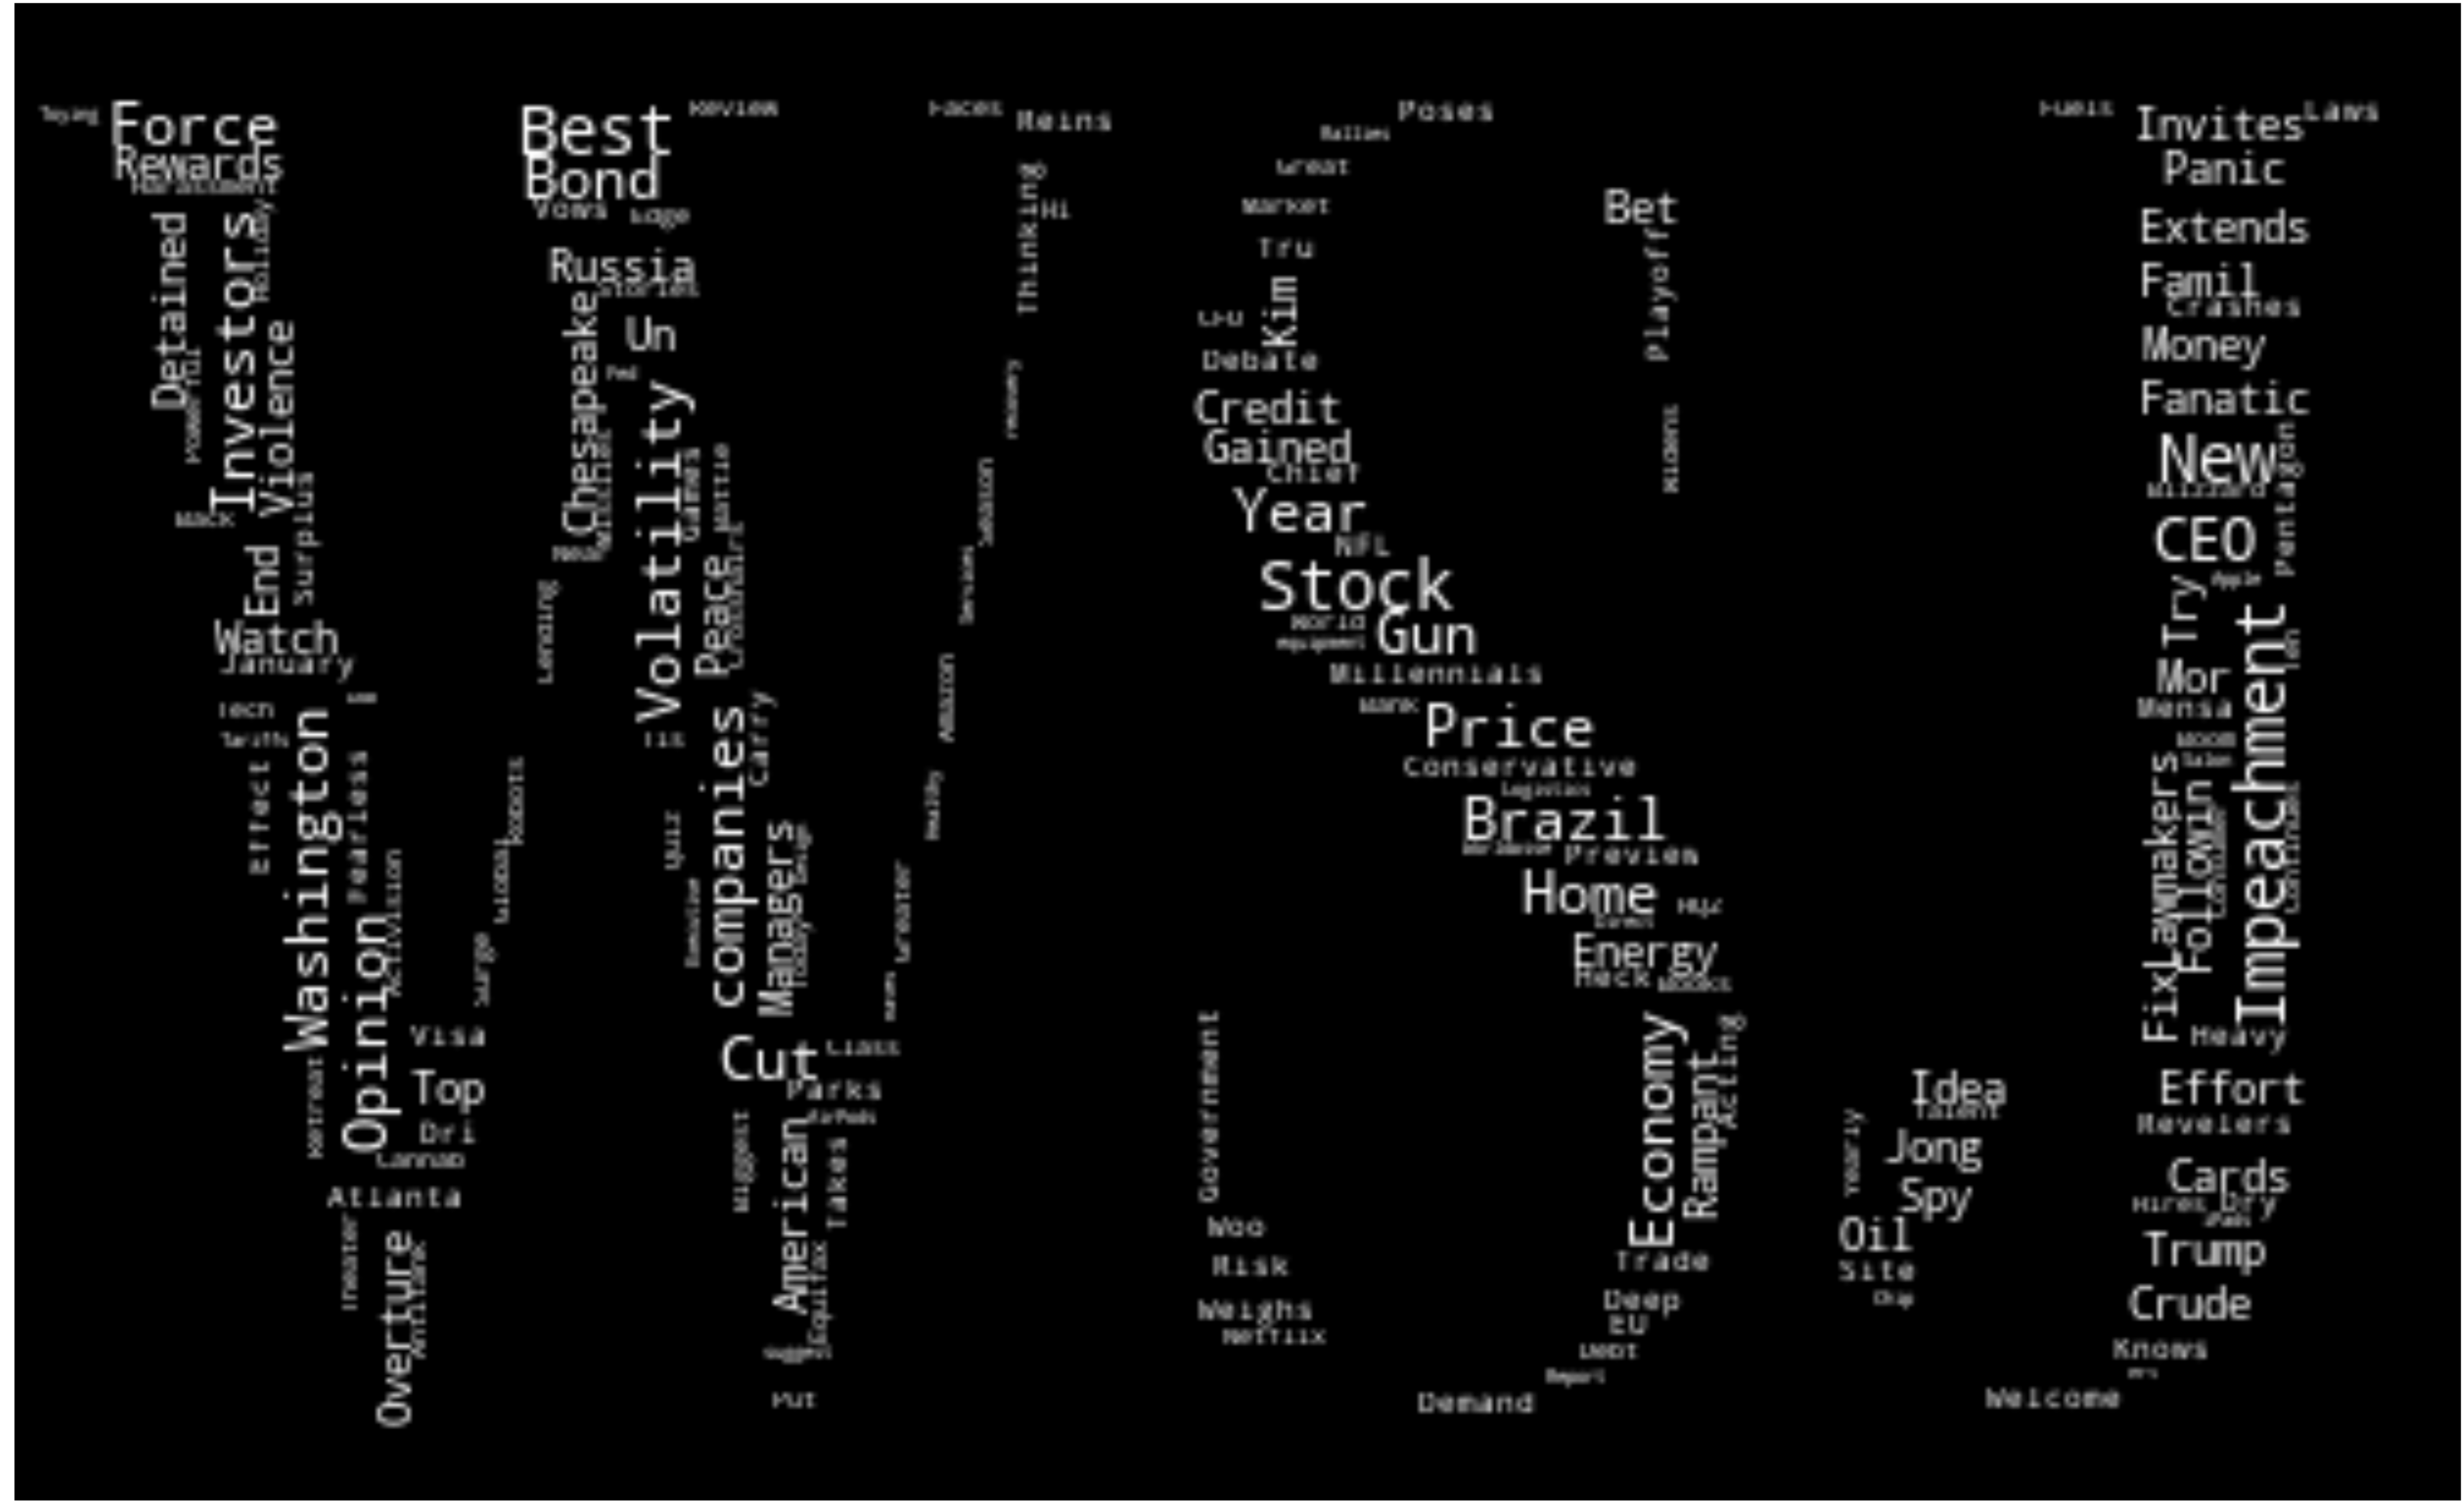

In [200]:
text= df['Text']

wordcloud = WordCloud(stopwords=stopwords_list, max_words=200, background_color="black",mask=wsj_mask, color_func=(lambda *args, **kwargs: "white")).generate(str(text))

# Display the generated image:
plt.figure(figsize=(100,100))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


88 of the top 100 positive change SP 500 days were also in the negative list. Now of these 88 I would like to do a absolute value to see which words have the most affect qoute on qoute.

## EDA Time Series Modeling

In [205]:
sp_500=pd.read_csv('S&P 500 Data.csv')

In [211]:
sp_500.set_index(sp_500['Date'],inplace=True)

In [215]:
sp_500.drop(['Date'],axis=1,inplace=True)

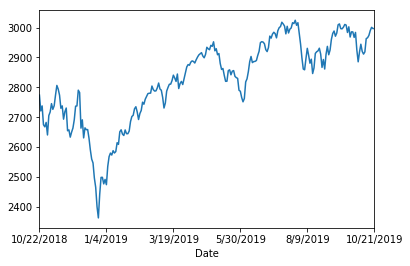

In [222]:
sp_500['Open'].plot()

In [225]:
sp_500['Change']=sp_500['Close']-sp_500['Open']

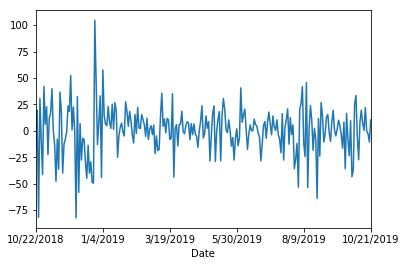

In [226]:
sp_500['Change'].plot()

## Baseline Model

In [354]:
final=pd.read_csv("Jan_Oct")

In [90]:
from sklearn.model_selection import train_test_split
X=df['Text']
y=df['Coded']

sent_train, sent_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=1)

In [91]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer= CountVectorizer()
vectorizer.fit(sent_train)

X_train= vectorizer.transform(sent_train)
X_test= vectorizer.transform(sent_test)


In [92]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

C:\Users\GBLS\AppData\Local\Continuum\anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.6455203116304953


Basic tokenization was used and achieved accuracy of 64 percent. The two paths forward are as follow: make the model more complex or tokenize the words differently by using bigrams or lemmentization. Hopefully, by isolating the models and only tweaking one aspect of the data/moddel we will improve our accuracy.

## Lemmentization

## Bigrams

In [194]:
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize

In [196]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
wsj_finder = BigramCollocationFinder.from_words(df_tokens)
wsj_scored = wsj_finder.score_ngrams(bigram_measures.raw_freq)
wsj_scored[:50]

[(('president', 'trump'), 0.0017477505802716874),
 (('new', 'york'), 0.0016830190772986618),
 (('logistics', 'report'), 0.0009216533042349815),
 (('today', 'logistics'), 0.0009216533042349815),
 (('trump', 'administration'), 0.0009154883991899314),
 (('hong', 'kong'), 0.0008939112315322563),
 (('white', 'house'), 0.0008939112315322563),
 (('wall', 'street'), 0.0006473150297302546),
 (('morning', 'risk'), 0.0006010782418923793),
 (('risk', 'report'), 0.0006010782418923793),
 (('737', 'max'), 0.0005579239065770289),
 (('morning', 'download'), 0.0004901099510814785),
 (('york', 'city'), 0.0004746976884688534),
 (('supreme', 'court'), 0.0004407907107210781),
 (('prime', 'minister'), 0.0004315433531535031),
 (('great', 'escapes'), 0.000422295995585928),
 (('justice', 'department'), 0.00040380128045077785),
 (('last', 'year'), 0.0003791416602705777),
 (('north', 'korea'), 0.0003760592077480527),
 (('paid', 'program'), 0.00037297675522552764),
 (('pg', 'e'), 0.0003575644926129025),
 (('federa

In [197]:
wsj_pmi_finder = BigramCollocationFinder.from_words(df_tokens)
wsj_pmi_finder.apply_freq_filter(5)
wsj_pmi_scored = wsj_pmi_finder.score_ngrams(bigram_measures.pmi)
wsj_pmi_scored

[(('abdelaziz', 'bouteflika'), 15.985561800747938),
 (('clayton', 'kershaw'), 15.985561800747938),
 (('edith', 'wharton'), 15.985561800747938),
 (('f.h', 'bertling'), 15.985561800747938),
 (('fire-', 'paparazzi-proofed'), 15.985561800747938),
 (('harriet', 'tubman'), 15.985561800747938),
 (('history—and', 'odds—are'), 15.985561800747938),
 (('javad', 'zarif'), 15.985561800747938),
 (('johns', 'hopkins'), 15.985561800747938),
 (('karlie', 'kloss'), 15.985561800747938),
 (('kershaw', 'fastball'), 15.985561800747938),
 (('lil', 'nas'), 15.985561800747938),
 (('lópez', 'obrador'), 15.985561800747938),
 (('nipsey', 'hussle'), 15.985561800747938),
 (('questions—and', 'answers—coming'), 15.985561800747938),
 (('randall', 'stephenson'), 15.985561800747938),
 (('sous', 'vide'), 15.985561800747938),
 (('triple—or', 'better—in'), 15.985561800747938),
 (('abn', 'amro'), 15.722527394914142),
 (('achilles', 'tendon'), 15.722527394914142),
 (('andrés', 'manuel'), 15.722527394914142),
 (('b-12', 'defi

Voting classifier look into this

## Neural Network 

In [93]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [94]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                213700    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 213,711
Trainable params: 213,711
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10,verbose=False,validation_data=(X_test, y_test),batch_size=10)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [102]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
# from keras.layers.embeddings import Embedding
# model = Sequential()
# model.add(Embedding(20000, 100))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# ## Fit the model
# model.fit(X_train, y_train, validation_split=0.4, epochs=3)

__Accuracies of Models for Similar Experiment__  
Logistic Regression 0.57  
Linear Discriminant Analysis 0.51  
K-Nearest Neighbors 0.46  
Decision Tree Classifier 0.49  
Support Vector Machine 0.53  
Random Forrest 0.50  
Extreme Gradient Boosting 0.52  
Naive Bayes 0.53  
LSTM 0.55  
MLP 0.53  


https://stackoverflow.com/questions/17870528/double-clicking-in-python-selenium